In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, precision_recall_curve, auc,
    make_scorer, fbeta_score, matthews_corrcoef, f1_score, RocCurveDisplay, PrecisionRecallDisplay
)

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, GroupKFold, GroupShuffleSplit, StratifiedGroupKFold, validation_curve, learning_curve
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, label_binarize

pd.set_option("display.max_columns", 150)
RANDOM_STATE = 42


TEST_SIZE = 0.20
MAX_ROWS = 15000

In [5]:
#load dataset
dataset_path = "../../data/processed/COEN498-691_HAR_preprocessed_dataset.csv"
dataset_df = pd.read_csv(dataset_path)
print("[INFO] Shape: ", dataset_df.shape)

#drop uneeded columns
X = dataset_df.drop(['activity_id', 'participant_id'], axis=1)
#keep type of activity
y = dataset_df['activity_id']
#participant_id for group-k-fold (if needed)
groups = dataset_df['participant_id']

print("[INFO] Shape: ", X.shape)

[INFO] Shape:  (4751, 39)
[INFO] Shape:  (4751, 37)


,ax_mean,ax_std,ax_max,ax_min,ax_range,ax_skew,ax_kurt,ax_zcr,ay_mean,ay_std,ay_max,ay_min,ay_range,ay_skew,ay_kurt,ay_zcr,az_mean,az_std,az_max,az_min,az_range,az_skew,az_kurt,az_zcr,sma,corr_axy,corr_axz,corr_ayz,axG_mean,ayG_mean,azG_mean,Gx,Gy,Gz,Gx_angle,Gy_angle,Gz_angle,activity_id,participant_id
0,-0.002040,0.007937,0.013687,-0.024382,0.038069,-0.428371,1.735067,0,0.000018,0.003702,0.008082,-0.006213,0.014295,0.305729,-0.440255,0,0.002910,0.004423,0.010936,-0.004582,0.015518,-0.031001,-1.009517,0,0.228077,0.454637,0.272721,0.257781,0.068392,-1.023843,0.187873,0.065561,-0.981462,0.180096,1.505189,2.948741,1.389712,1,LL
1,0.004890,0.009201,0.032755,-0.011421,0.044177,1.177575,2.846603,0,0.001896,0.004891,0.008731,-0.015260,0.023991,-1.694765,5.425193,0,0.004299,0.005837,0.024398,-0.004582,0.028980,1.667282,4.999686,0,0.272588,-0.571308,0.538310,-0.346575,0.072325,-1.023652,0.190706,0.069292,-0.980722,0.182708,1.501449,2.944921,1.387056,1,LL
2,-0.010652,0.043875,0.070725,-0.110145,0.180870,-0.535210,0.442954,6,-0.003511,0.019515,0.040681,-0.055304,0.095985,-0.520642,1.456972,2,-0.011698,0.032911,0.050812,-0.080642,0.131454,-0.783091,0.237761,5,1.136790,-0.166030,0.608269,0.281542,0.076422,-1.023306,0.193795,0.073180,-0.979901,0.185575,1.497551,2.940762,1.384139,1,LL


ax_mean     0.0
ayG_mean    0.0
az_kurt     0.0
az_zcr      0.0
sma         0.0
corr_axy    0.0
corr_axz    0.0
corr_ayz    0.0
axG_mean    0.0
azG_mean    0.0
dtype: float64

sma         105.666205
ax_zcr       17.063525
ay_zcr       15.168033
az_zcr       12.808488
ay_kurt       1.624260
ay_range      1.399250
ax_kurt       1.324771
az_kurt       1.145134
ax_range      0.607842
ay_min        0.454196
dtype: float64

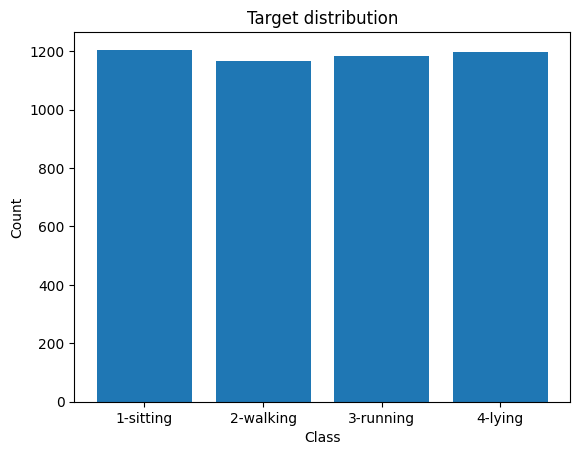

In [6]:
#eda
display(dataset_df.head(3))

#any missing
miss_pct = dataset_df.isna().mean().mul(100).sort_values(ascending=False).head(10)
display(miss_pct)

#variance of features
var_top = X.var().sort_values(ascending=False).head(10)
display(var_top)

#bar graph
plt.figure()
counts = y.value_counts().sort_index()
plt.bar(['1-sitting', '2-walking', '3-running', '4-lying'], counts.values)
plt.title("Target distribution"); plt.xlabel("Class"); plt.ylabel("Count")
plt.show()


In [7]:
#groupshuffle and split into train and test
gss = GroupShuffleSplit(n_splits=1, test_size=TEST_SIZE, random_state=RANDOM_STATE)
train_idx, test_idx = next(gss.split(X, y, groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]


print("[INFO] Train: ", X_train.shape),
print("Test: ", X_test.shape)
print("[INFO] Train class counts:\n", y_train.value_counts())
print("[INFO] Test  class counts:\n", y_test.value_counts())


[INFO] Train:  (3801, 37)
Test:  (950, 37)
[INFO] Train class counts:
 activity_id
1    969
3    953
4    948
2    931
Name: count, dtype: int64
[INFO] Test  class counts:
 activity_id
4    248
1    236
2    235
3    231
Name: count, dtype: int64


In [8]:
#pipeline
def build_pipeline(scaler, n_neighbors=5, metric="euclidean", weights="uniform"):
    steps = [("imputer", SimpleImputer(strategy="median"))]
    if scaler is not None:
        steps.append(("scaler", scaler))
    steps.append(("knn", KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric, weights=weights)))
    return Pipeline(steps)

#stratified-k-fold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
#group-k-fold
gkf = GroupKFold(n_splits=5)
#stratified-group-k-fold
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

In [9]:
#No scaler
pipe_noscaler = build_pipeline(scaler=None, n_neighbors=5, metric="euclidean", weights="uniform")  # pass a scaler instance
pipe_noscaler.fit(X_train, y_train)
y_pred_noscaler = pipe_noscaler.predict(X_test)
print("[INFO] Done training with no scaler & predict")


[INFO] Done training with no scaler & predict


In [10]:
#try different scaler
#MinMaxScaler()
pipe_minmax = build_pipeline(scaler=MinMaxScaler(), n_neighbors=5, metric="euclidean", weights="uniform")  # pass a scaler instance
pipe_minmax.fit(X_train, y_train)
y_pred_minmax = pipe_minmax.predict(X_test)
print("[INFO] Done training with MinMax scaler & predict")


[INFO] Done training with MinMax scaler & predict


In [11]:
#try different scaler
#StandardScaler()
pipe_standard = build_pipeline(scaler=StandardScaler(), n_neighbors=5, metric="euclidean", weights="uniform")  # pass a scaler instance
pipe_standard.fit(X_train, y_train)
y_pred_standard = pipe_standard.predict(X_test)
print("[INFO] Done training with Standard scaler & predict")


[INFO] Done training with Standard scaler & predict


No Scaler
Accuracy:  0.9936842105263158
Classification Report:
               precision    recall  f1-score   support

           1       0.98      1.00      0.99       236
           2       1.00      0.99      1.00       235
           3       1.00      1.00      1.00       231
           4       1.00      0.99      0.99       248

    accuracy                           0.99       950
   macro avg       0.99      0.99      0.99       950
weighted avg       0.99      0.99      0.99       950

MinMax Scaler
Accuracy:  0.9989473684210526
Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00       236
           2       1.00      1.00      1.00       235
           3       1.00      1.00      1.00       231
           4       1.00      1.00      1.00       248

    accuracy                           1.00       950
   macro avg       1.00      1.00      1.00       950
weighted avg       1.00      1.00      1.00       950

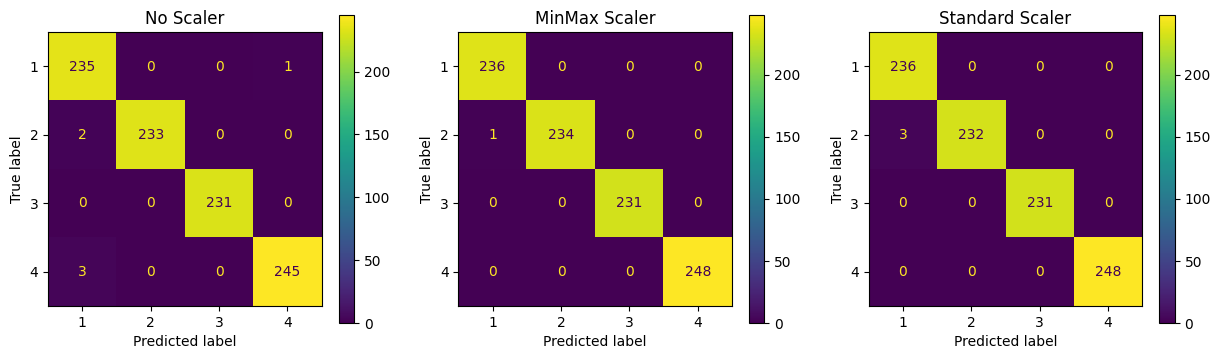

In [12]:
#evaluate NoScaler
print("No Scaler")
print("Accuracy: ", accuracy_score(y_test, y_pred_noscaler))
print("Classification Report:\n", classification_report(y_test, y_pred_noscaler))

#evaluate MinMaxSacler
print("MinMax Scaler")
print("Accuracy: ", accuracy_score(y_test, y_pred_minmax))
print("Classification Report:\n", classification_report(y_test, y_pred_minmax))

#evaluate Standard Scaler
print("Standard Scaler")
print("Accuracy: ", accuracy_score(y_test, y_pred_standard))
print("Classification Report:\n", classification_report(y_test, y_pred_standard))



#set plots of confusion matrix
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

#confusion matrix No Scaler
cm_noscaler = confusion_matrix(y_test, y_pred_noscaler)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_noscaler, display_labels=pipe_noscaler.named_steps["knn"].classes_)
axes[0].set_title("No Scaler")
disp.plot(ax=axes[0])

#confusion matrix MinMaxScaler
cm_minmax = confusion_matrix(y_test, y_pred_minmax)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_minmax, display_labels=pipe_minmax.named_steps["knn"].classes_)
axes[1].set_title("MinMax Scaler")
disp.plot(ax=axes[1])

#confusion matrix Standard Scaler
cm_standard = confusion_matrix(y_test, y_pred_standard)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_standard, display_labels=pipe_standard.named_steps["knn"].classes_)
axes[2].set_title("Standard Scaler")
disp.plot(ax=axes[2])